In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3817833122831596934
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 101765120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17470531898978571029
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


# Neural network for string detection

## Temporal data

We'll use the same dataset as in the note detection case

In [59]:
data = pd.read_pickle("../../Data/Guitar/guitar-string-data-500.pkl")

In [60]:
data.shape

(7175, 501)

In [5]:
data["String"] = data["String"].values.astype("int") - 1

In [6]:
data["String"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [4]:
def create_xy(df, target_column):
    return df.drop(target_column, axis=1), df[target_column]

def split_data(df, target_column):
    X_train, y_train = create_xy(df.sample(round(0.8*df.shape[0])), target_column)
    df = df.drop(X_train.index)
    X_val, y_val = create_xy(df.sample(round(0.5*df.shape[0])), target_column)
    df = df.drop(X_val.index)
    X_test, y_test = create_xy(df, target_column)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "String")

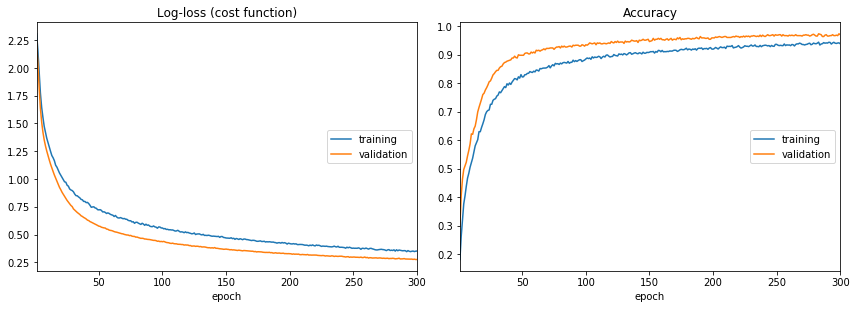

Log-loss (cost function):
training   (min:    0.346, max:    2.306, cur:    0.351)
validation (min:    0.275, max:    2.236, cur:    0.275)

Accuracy:
training   (min:    0.181, max:    0.943, cur:    0.938)
validation (min:    0.301, max:    0.973, cur:    0.970)
Train score: 0.26919885948157524
Train accuracy: 0.9710957085184424
Validation score: 0.27517912021050084
Validation accuracy: 0.969551282051282


In [54]:
inputs = Input(shape=(500,))
hidden1 = Dense(128, kernel_regularizer=l2(0.001), activation="relu")(inputs)
hidden1_drop = Dropout(0.4)(hidden1)
hidden2 = Dense(64, kernel_regularizer=l2(0.001), activation="relu")(hidden1_drop)
hidden2_drop = Dropout(0.4)(hidden2)
preds = Dense(8, activation="softmax")(hidden2_drop)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=300, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

NOTE: At first, the accuracy of this model was relatively low, unlike now that it has been revisited. This is why I moved on to use spectral data

## Spectral data

Let's train the NN with data from the frequency domain

In [55]:
data = pd.read_pickle("../../Data/Guitar/guitar-spectral-string-data-500.pkl")

In [56]:
data["String"] = data["String"].values.astype("int") - 1

In [57]:
data["String"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [58]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "String")

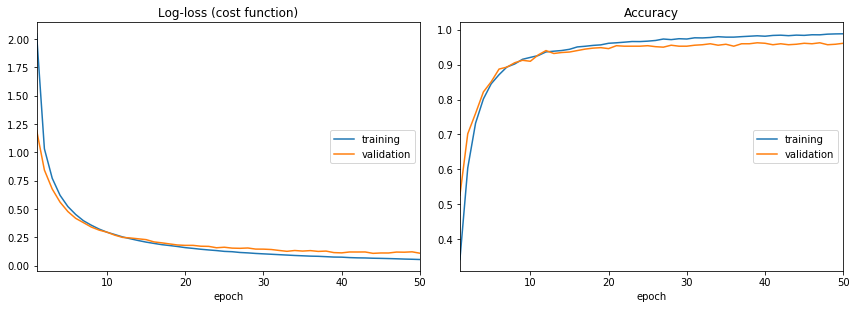

Log-loss (cost function):
training   (min:    0.055, max:    2.047, cur:    0.055)
validation (min:    0.109, max:    1.198, cur:    0.110)

Accuracy:
training   (min:    0.342, max:    0.988, cur:    0.988)
validation (min:    0.526, max:    0.962, cur:    0.961)
Train score: 0.050749065597194415
Train accuracy: 0.9914634146341463
Validation score: 0.11011112304949162
Validation accuracy: 0.9610027855153204


In [10]:
inputs = Input(shape=(500,))
hidden1 = Dense(256)(inputs)
hidden2 = Dense(128, activation="relu")(hidden1)
preds = Dense(8, activation="softmax")(hidden2)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=50, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

Save the model

In [11]:
model.save_weights('Guitar_string_NN_weights.h5')

In [12]:
with open('Guitar_string_NN_architecture.json', 'w') as f:
    f.write(model.to_json())

## Normalized spectral data

In [10]:
%run ../../Utilities/Utilities.ipynb

Working with normalized data might help when testing new cases, as the last one performed worse than expected

In [16]:
data = pd.read_pickle("../../Data/Guitar/guitar-norm-spectral-string-data-500.pkl")
data = data.reset_index(drop=True)

Data from riffs was added to provide more realistic cases

In [17]:
data.shape

(11980, 501)

In [18]:
data["String"] = data["String"].values.astype("int") - 1

In [19]:
data["String"].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [20]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "String")

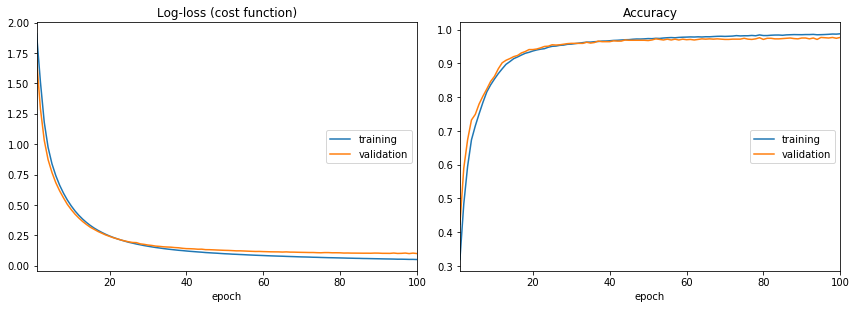

Log-loss (cost function):
training   (min:    0.051, max:    1.908, cur:    0.051)
validation (min:    0.100, max:    1.698, cur:    0.100)

Accuracy:
training   (min:    0.319, max:    0.987, cur:    0.987)
validation (min:    0.423, max:    0.977, cur:    0.977)
Train score: 0.04939426665073059
Train accuracy: 0.9875834724540902
Validation score: 0.10038993100889139
Validation accuracy: 0.9766277125562371


In [21]:
inputs = Input(shape=(500,))
hidden1 = Dense(256)(inputs)
hidden2 = Dense(128, activation="relu")(hidden1)
preds = Dense(8, activation="softmax")(hidden2)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.00005)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=None, epochs=100, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

score_train = model.evaluate(X_train, y_train, verbose=0)
score_val = model.evaluate(X_val, y_val, verbose=0)

score_test = model.evaluate(X_test, y_test, verbose=0) 
print('Train score:', score_train[0])
print('Train accuracy:', score_train[1])
print('Validation score:', score_val[0])
print('Validation accuracy:', score_val[1])

In [22]:
model.save_weights('Guitar_norm_string_NN_weights.h5')

In [23]:
with open('Guitar_norm_string_NN_architecture.json', 'w') as f:
    f.write(model.to_json())

Let's test this with a completely new riff

In [14]:
%run ../../Utilities/Utilities.ipynb

In [16]:
y = load_file("../../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3", 8000)

One beat is equal to 3000 samples at 160 bpm and 8000 Hz

In [25]:
8000 * 60 * 1/160

3000.0

In [26]:
test = spectral_data(y[:1500], 500, True)

Correct prediction for the first note

In [27]:
np.argmax(model.predict(test)) + 1

4

In [28]:
results = apply_window(y, 500, 1500, False, True, model.predict)

String prediction for the 6th and 8th notes are wrong. However, this is because the segmentation is inaccurate

In [47]:
for _ in results:
    print(np.argmax(_[1]) + 1)

4
5
4
5
4
4
4
4


In [31]:
ipd.Audio("../../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3")

Let's retry with manually set onsets

In [40]:
onsets = [0, 1500, 3000, 4500, 6200, 7700, 9200, 10900, len(y)]

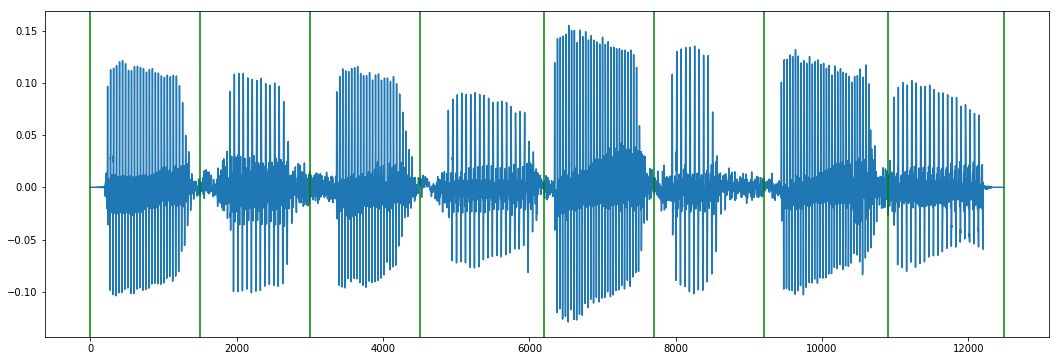

In [41]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in onsets:
    plt.axvline(x=i, color="g")

Now all notes are correct!

In [51]:
for i in range(len(onsets) - 1):
    data = spectral_data(y[onsets[i]:onsets[i+1]], 500, True)
    print(np.argmax(model.predict(data)) + 1)

4
5
4
5
4
5
4
5
